In [3]:
# Imports, wiederkehrende Daten und Funktionen
from matplotlib      import pyplot
from matplotlib      import lines
from pandas          import concat
from pandas          import DataFrame
from scipy.integrate import quad
from scipy.optimize  import minimize
from scipy.stats     import genextreme
from scipy.stats     import norm
from seaborn         import heatmap
import math
import networkx
import numpy
import random

μ_aminosäuren = {'A':  71.08, 
                 'C': 103.14,
                 'D': 115.09, 
                 'E': 129.12, 
                 'F': 147.18, 
                 'G':  57.05,
                 'H': 137.14,
                 'I': 113.16, 
                 'K': 128.18, 
                 'L': 113.16, 
                 'M': 131.20, 
                 'N': 114.10, 
                 'P':  97.12, 
                 'Q': 128.13, 
                 'R': 156.19, 
                 'S':  87.08,
                 'T': 101.11,
                 'V':  99.13,
                 'W': 186.21,
                 'Y': 163.18}

μ_abcd = {'a':  2,
          'b':  3,
          'c':  7,
          'd': 12}

def invers(function: dict):
    return {value: key for key, value in function.items()}

def gewicht(string, μ):
    return sum([μ[s] for s in string])

def generiere_präfixe(string):
    return [string[0:i] for i in range(len(string)+1)]

def generiere_suffixe(string):
    return [string[i:len(string)+1] for i in range(len(string)+1)]

# Algorithmische Massenspektometrie
### Jupyter-Notebook von Simon Hegele basierend auf der Vorlesung von Prof. Dr. Sebastian Böcker (Friedrich-Schiller-Universität Jena)

In diesem Notebook gebe ich kurze Rückblicke auf die Inhalte der Vorlesung von und implementiere einige der vorgestellten Konzepte und Methoden.<br>

Bemerkungen:<br>
a) Obwohl ich Beispiele aus den Übungsserien verwende geht es hier nicht um die Abarbeitung der Übungsserien.<br>
b) Die Beispiele können leicht geändert werden. In jeder Code-Zeile gibt es ein Feld mit klar markierten Zeilen für die Benutzereingabe.

# 0 Einführung

Molekülmassen können indirekt bestimmt und unterschieden werden, weil die Flugbahn von Ionen von elektromagnetischen Feldern gemäß des **Masse-zu-Ladungsverhältnis** beeinflusst werden. Ein Massenspektrometer besteht im Wesentlichen aus drei Modulen mit unterschiedlichen Aufgaben:
- Ionisierung
- Auftrennung der Ionen nach Masse-zu-Ladungsverhältnis durch ein elektromagnetisches Feld
- Detektion der Ionen
<br><br>

<div style="display:flex">
    <div style="width:45%; margin-right:5%">
        <img src="Abbildungen\Aufbau-Massenspektrometer.png" alt="Aufbau eines Massenspektrometer" style="width: 75%">
        <p>Abb 1: Aufbau eines Massenspektrometer</p>
    </div>
    <div style="width:45%">
        <img src="Abbildungen\Massenspektrum-Beispiel.jpg" alt="Beispielhaftes Masssenspektrum" style="width: 75%">
    <p>Abb 2: Beispielhaftes Massenspektrum</p>
    </div>
</div>

Das Ergebnis einer Messung mit dem Massenspektrometer ist eine Reihe von Intensitäten für verschiedene Masse-zu-Ladungsverhältnisse

# 1 Analyse von Biomolekülen

## 1.1 Schritte der einfachen Massenspektometrie
1. **Biochemische Vorverarbeitung** (Gewinnung der Probe)
- Lyse der Zelle
- Extraktion
- Deaktivieren von Enzymen
- ...
2. **Auftrennen der Probe** (Komplexitätsreduktion)
- 2D-Gelelektrophorese          (Proteomik)
- LC (Flüssig-Chromatographie)  (Proteomik, Metabolomik)
- GC (Gas-Chromatographie)      (Metabolomik)
3. **Massenspektrometrie**
- Ionisierung: MALDI (Matrix Assisted Laser Desorption Ionization) oder ESI (Electrospray Ionization)
- Analyse: Quadrupol, TOFMS, oder Ionenfalle
- Detektion: Elektronenmultiplizierer
4. **Datenanalyse**
- Vorverarbeitung: Rauschen filtern, Baseline entfernen und Peak-picking
- Analyse der Peaklisten

## 1.2 Massenspektrometrie für Proteine, Shotgun-proteomics, Tandem-Massenspektrometrie

### 1.2.1 Gewichtete Alphabete

Peptide sind Polymere aus Aminosäuren und können als Strings $s=s_1,s_2,...,s_n$ repräsentiert werden. Die Summenformeln und (monoistotope) Massen von Aminosäuren sind bekannt.

Wir definieren ein **gewichtetes Alphabet $(\Sigma,\mu)$** mit $\Sigma=\{A,C,D,...\}$ (die Buchstabencodes der Aminosäuren) und $\mu:\Sigma\rightarrow\mathbb{R}_0^+$ (Abbildung von den Buchstabencodes der Aminosäure auf die Massen der Aminosäuren). Wir definieren das Gewicht eines Peptid $s\in\Sigma^*$ als $\mu(s)=\sum_ {i=1}^{n}\mu(s_i)$<br>
Bemerkungen:<br>
a) Die in der Vorlesung behandelten Methoden funktionieren auch für beliebige andere gewichtete Alphabete.<br>
b) Wir nehmen üblicherweise ganzzahlige Massen an (durch Runden und Stellen verschieben für alle Gewichte).

### 1.2.2. Shotgun-Proteomics, Tandem-Massenspektrometrie

Probleme von einfacher Massenspektrometrie für Proteine:
- Messfehler steigt mit Molekülmasse
- Wenig Information (Aminosäresequenz bleibt unbekannt)

Erweiterterungen des Massenspektrometrie-Verfahren:<br>
1. **Trypsin-Verdau** (Schnitt nach Lysin K oder Arginin R, außer nach Prolin P)


In [4]:
def einfacher_trypsin_schnitt(peptid: str):
    '''
    Gibt eine Liste der Peptidpaare zurück, die durch einen einfachen 
    Schnitt mit Trypsin aus dem Eingabe-Peptid enstehen können
    '''
    cleaving_sites = [i for i in range(len(peptid)-1) if (peptid[i]=='K' or peptid[i]=='R') and not peptid[i+1]=='P']
    if cleaving_sites:
        return [(peptid[:cleaving_site+1], peptid[cleaving_site+1:]) for cleaving_site in cleaving_sites]
    return peptid

def trypsischer_verdau(peptid: str, vollständig: bool=False):
    '''
    Gibt die Menge aller Peptide zurück, die bei einem vollständigem
    oder unvollständigem tryptischen Verdau des Peptids entstehen können.
    
    (Rekursion)
    '''
    fragmente = set([peptid])
    if not peptid == einfacher_trypsin_schnitt(peptid):
        for cut in einfacher_trypsin_schnitt(peptid):
            if vollständig:
                fragmente = trypsischer_verdau(cut[0], vollständig)|trypsischer_verdau(cut[1], vollständig)
            else:
                fragmente = fragmente|trypsischer_verdau(cut[0], vollständig)|trypsischer_verdau(cut[1], vollständig)
    return fragmente

def peptid_ionen_masse(peptid: str, μ: dict, ladung: int=1):
    return sum([μ[s] for s in peptid]) + 18.01 + ladung*1.01    

###################################
#---------------------------------#
protein  = 'WMARRPMRPWKRCNPRKPNWVT'
vollständiger_verdau = False
#---------------------------------#
###################################

# Mögliche Trypsin-Schnitte
cuts =  einfacher_trypsin_schnitt(protein)
print(f'Mögliche Peptidschnitte von {protein} durch Trypsin:')
if type(cuts)==str:
    print('Keine mögliche Schnitte')
else:
    for cut in cuts:
        print(cut)
print()

# Peptide aus Trypsinverdau mit Molekülmassen
s = lambda c: 'vollständigem' if c else 'unvollständigem'
print(f'Fragmente aus einem {s(vollständiger_verdau)} tryptischen Verdau von {protein} mit Ionenmassen:')
fragmente = sorted(list(trypsischer_verdau(protein, vollständiger_verdau)), key=len)
massen    = map(lambda x: peptid_ionen_masse(x, μ_aminosäuren), fragmente)
display(DataFrame({'Peptide': fragmente, 'Peptidmassen': massen}))

# m/z-Werte für verschiedene Ladungszahlen
print('m/z-Werte der Muttermasse für verschiedene Ladungen')
ladungen = range(1,4)
m_z      = map(lambda x: round(peptid_ionen_masse(protein, μ_aminosäuren, x)/x,2), ladungen)
display(DataFrame({'Ladung': ladungen, 'm/z-Wert': m_z}))

Mögliche Peptidschnitte von WMARRPMRPWKRCNPRKPNWVT durch Trypsin:
('WMAR', 'RPMRPWKRCNPRKPNWVT')
('WMARRPMRPWK', 'RCNPRKPNWVT')
('WMARRPMRPWKR', 'CNPRKPNWVT')
('WMARRPMRPWKRCNPR', 'KPNWVT')

Fragmente aus einem unvollständigem tryptischen Verdau von WMARRPMRPWKRCNPRKPNWVT mit Ionenmassen:


,Peptide,Peptidmassen
0,R,175.21
1,CNPR,489.57
2,WMAR,563.70
3,RCNPR,645.76
4,KPNWVT,744.87
5,RPMRPWK,971.23
6,RPMRPWKR,1127.42
7,CNPRKPNWVT,1215.42
8,WMARRPMRPWK,1515.91
9,RCNPRKPNWVT,1371.61


m/z-Werte der Muttermasse für verschiedene Ladungen


,Ladung,m/z-Wert
0,1,2868.50
1,2,1434.76
2,3,956.84


2. **Auftrennung der Probe nach Retentionszeit**
- HPLC (Hochdruckflüssigkeitschromatographie)
- Umkehrphasen-Chromatographie

Auftrennung der Proteine nach physikalischen Eigenschaften über Molekülinteraktionen in einer Säule. Die Zeit, die eine Molekül benötigt um die Säule zu durchwandern heißt Retentionszeit<br>
(Bemerkung: Die Probe kann die Eigenschaften der Säule beeinflussen, daher lassen sich keine exakten Aussagen über Moleküleigenschaften aufgrund der Retentionszeit treffen)

3. **CID (Collision induced dissociation)**

In Tandem-Massenspektrometern gibt es zwei Analyse-Module mit zwischengeschalteter Kollisionszelle mit Halogen- oder Stickstoffgas zur Fragmentierung durch **CID** (Collision induced dissociation) von Biomolekülen. Bei CID kann ein Protein praktisch an jeder Position die Bindung brechen. Weiterhin wird dabei kein Wasser angelagert. Daher entspricht die Masse eines b-Ions (Suffix) gleich der Summe der Massen der Aminos¨aureresten plus dem Proton. Die Masse des y-Ions (Präfix) hingegen entspricht der Summe der Massen der Aminos¨aurereste plus der Masse von Wasser.


In [5]:
def b_ionen_masse(peptid, μ):
    return gewicht(peptid, μ) + 1.01

def y_ionen_masse(peptid, μ):
    return gewicht(peptid, μ) + 19.02

def kollisions_induzierte_dissoziation(peptid, μ):
    b_ionen        = [b for b in generiere_präfixe(peptid) if not b=='']
    b_ionen_massen = list(map(lambda x: b_ionen_masse(x, μ), b_ionen))
    b_ionen_data   = DataFrame({'Sequenz': b_ionen, 'Massen': b_ionen_massen})
    y_ionen        = [y for y in generiere_suffixe(peptid) if not y=='']
    y_ionen_massen = list(map(lambda x: y_ionen_masse(x, μ), y_ionen))
    y_ionen_data   = DataFrame({'Sequenz': y_ionen, 'Massen': y_ionen_massen})
    return b_ionen_data, y_ionen_data

###############
#-------------#
peptid = 'WMAR'
#-------------#
###############

print(f'CID für {peptid}:\n')
b_ionen_data, y_ionen_data = kollisions_induzierte_dissoziation(peptid, μ_aminosäuren)
print('b-Ionen:')
display(b_ionen_data)
print('y-Ionen:')
display(y_ionen_data)
print('Hier wird eine mögliche Nicht-Kollision miteinbezogen')

CID für WMAR:

b-Ionen:


,Sequenz,Massen
0,W,187.22
1,WM,318.42
2,WMA,389.50
3,WMAR,545.69


y-Ionen:


,Sequenz,Massen
0,WMAR,563.70
1,MAR,377.49
2,AR,246.29
3,R,175.21


Hier wird eine mögliche Nicht-Kollision miteinbezogen


In der nachfolgenden Abbildung sehen wir nochmal den schematischen Ablauf der Shotgun-Proteomics.
Man beginnt mit der biochemischen Vorverarbeitung. Anschließend werden die extrahierten Proteine mit Trypsin verdaut. Die resultierenden Peptide werden chromatografisch aufgetrennt. Mit einem ersten Massenspektrometrieschritt wird ein zweidmensionales Spektrum (Masse/Ladung, Retentionszeit) erstellt. Für interessante (intensive) Peaks werden die Peptide, die diese Peaks verursachen in der Kollisionszelle fragmentiert. Für die Fragmente werden dann in mit einer zweiten Analysezelle eigene massenspektren erstellt. Zur Effizienzsteigerung finden die Schritte weitestgehend parallel statt.<br>
<img src="Abbildungen\Shotgun-Proteomics.png" style="width: 50%"><br>
Abb 3: Schematische Übersicht zu den Schritten der Shotgun-Proteomics

# 2 Peptid De novo Sequenzierung I<br>Rekonstruktion von Strings aus idealen MS-Daten mit dynamischer Programmierung

Sequenzieren von Proteinen ohne Datenbank.

### 2.1. Formale Problemstellung
**Gegeben:**
- **gewichtetes Alphabet** $(\Sigma,\mu)$
- **Spektrum** $M$ eines Strings $s\in\Sigma^*$ (Gewichte aller Präfixe und Suffixe)

**Gesucht:**
- s mit $M(s)=M$

$\rightarrow$ Rekonstruiere s aus $M$

In diesem Teil gehen wir vereinfachend von idealen Daten aus:
- keine zusätzlichen Peaks (False positives)
- keine fehlenden Peaks
- für alle echten Suffixe $s$ und alle echten Präfixe $p$ gilt $\mu(s)\neq\mu(p)$ **(*)** 

Aus der letzten Annahme folgt, dass Strings der Länge $n$ $2n$ Massen in $M$ erzeugen.

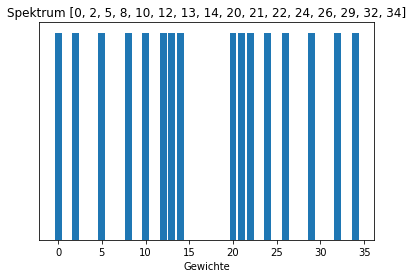

In [6]:
def generiere_spektrum(string, μ):
    präfixe       = generiere_präfixe(string)
    suffixe       = generiere_suffixe(string)
    präfix_massen = list(map(lambda x: gewicht(x, μ), präfixe))
    suffix_massen = list(map(lambda x: gewicht(x, μ), suffixe))
    return sorted(list(set(präfix_massen+suffix_massen)))

def plot_spektum(axes, spektrum):
    massen   = range(spektrum[len(spektrum)-1]+1)
    axes.bar(massen, list(map(lambda masse: int(masse in spektrum), massen)))
    axes.set_xlabel('Gewichte')
    axes.set_title(f'Spektrum {spektrum}')
    axes.tick_params(left=False, labelleft=False)

###################
#-----------------#
string = 'abbabcad'
μ      = μ_abcd
#-----------------#
###################

spektrum = generiere_spektrum(string, μ)

fig, axes = pyplot.subplots()
plot_spektum(axes, spektrum)
pyplot.show()

### 2.1.2. Spektrum-Graph
- $V=M$
- $E=$ gerichtete Kanten von  $u$ nach $v$ gdw. $\exists(\sigma\in\Sigma): u+\mu(\sigma)=v$

Die nach $(\mu,<)$ geordneten Massen nennen wir $x_0,...,x_n,y_n,...,y_0$<br>

Wir konstruieren zwei Pfade im Spektrum-Grap vom $M$. Einer heißt Präfixpfad, der andere heißt Suffixpfad. Wegen **\*** sollen die Pfade (abgesehen von $x_0$) Knotendisjunkt sein. Außerdem wollen wir jede Masse **erklären** (Jeder Knoten soll Teil einer der beiden Pfade sein). Ein solches Paar von Pfaden nennen wir zulässig. Mit ihnen können wir den String rekonstruieren, der das Spektrum erzeugt hat.

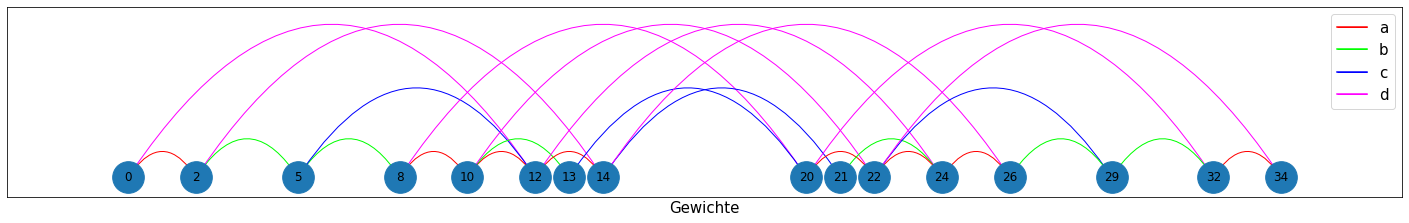

In [7]:
def generiere_spektrum_graph(spektrum: list, μ: dict, farben: list):
    G = networkx.DiGraph()
    μ_invers = invers(μ)
    for masse in spektrum:
        G.add_node(masse, pos=(masse,0))
    for i, masse_i in enumerate(spektrum):
        for j, masse_j in enumerate(spektrum[i+1:len(spektrum)]):
            for gewicht in μ_invers.keys():
                if masse_i+gewicht==masse_j:
                    G.add_edge(masse_i,masse_j, buchstabe=μ_invers[gewicht], farbe=farben[μ_invers[gewicht]])
    return G
   
def zeichne_spektrum_graph(ax, G, μ):
    # Knoten
    pos = networkx.get_node_attributes(G,'pos')
    networkx.draw_networkx_nodes(G, pos, node_size=1000)
    networkx.draw_networkx_labels(G, pos)
    # Kanten
    kanten = list(G.edges)
    kantenfarben = networkx.get_edge_attributes(G, 'farbe').values()
    networkx.draw_networkx_edges(G, pos, edgelist=kanten, edge_color=kantenfarben, connectionstyle='arc3, rad = -0.75', arrowstyle='->', ax=ax)
    # Labels
    ax.set_xlabel('Gewichte', fontsize=15)
    artists = (lines.Line2D(range(3), range(3), color=farben[buchstabe], marker="_", markersize=30) for buchstabe in μ.keys())
    ax.legend(artists, (buchstabe for buchstabe in μ.keys()), fontsize=15)
    ax.set_ylim(ymin=-len(G.nodes())*0.5)

def spektrum_graph(ax, spektrum, μ, farben):
    G = generiere_spektrum_graph(spektrum, μ, farben)
    zeichne_spektrum_graph(ax, G, μ)

####################################################
#--------------------------------------------------#
string = 'abbabcad'
μ      = μ_abcd
farben = {'a': '#ff0000',
          'b': '#00ff00',
          'c': '#0000ff',
          'd': '#ff00ff'}
#--------------------------------------------------#
####################################################

fig, axes = pyplot.subplots(figsize=(25,3.5))
spektrum_graph(axes, generiere_spektrum(string, μ), μ, farben)

## 2.3. Dynamische Programmierung

### 2.3.1. Definition der Matrix D

Wir definieren eine $nxn$-Matrix D
$$
D[i,j]:=
\left\{
\begin{aligned}
& 1 & falls:~Es~einen~Präfixpfad~von~x_0~zu~x_i~und~einen~Suffixpfad~von~x_0~zu~x_j,~die~zusammen~zulässig~sind\\
& 0 & sonst
\end{aligned}
\right.
$$

### 2.3.2. Berechnung der Matrix D

Die D-Matrix lässt sich in unterteilen in Diagonale, Nebendiagonalen und den Rest (siehe Grafik unten links). Die Werte werden jeweils unterschiedlich berechnet. Das lässt sich mit einigen Beobachtungen zu den verschiedenen Fällen (siehe Grafik unten rechts und Beschreibung unterhalb der Grafik) begründen.  Wir werden den Spektrum-Graphen hier nicht explizit erstellen, es reicht, dass wir Fragen nach der Existenz von Kanten beantworten können. Diese Anfragen lassen sich durch die Nutzung einer Hashmap für die Umkehrfunktion der Gewichtsfunktion in konstanter Zeit beantworten.

<div style="display:flex">
    <div style="width:45%; margin-right:5%">
        <img src="Abbildungen\D.png" style="width: 75%">
        <p>Abb 4: Schematische Darstellung der D-Matrix</p>
    </div>
    <div style="width:45%">
        <img src="Abbildungen\D-Cases.png" style="width: 41.5%">
    <p>Abb 5: Schematische Darstellung verschiedener Fälle bei der Berechnung von D</p>
    </div>
</div>

**Beobachtungen:**<br>
1. $D[0,0]=1$<br>

2. $D[i,j]=D[j,i]$<br>Symmetrie der Matrix (Bennenung der Pfade ist willkürlich)

3. $D[i,i]=0$ für $i>0$ (Diagonale)<br>Die Pfade wären nicht knotendisjunkt

4. $D[i,j]=max(\{D[l,j]|(x,_l,x_i) \in E\})$ für $i=j+1$<br>$D[i,j]=max(\{D[i,l]|(x,_l,x_j) \in E\})$ für $j=i+1$<br>(Nebendiagonale)

5. $
D[i,j]:=
\left\{
\begin{aligned}
& 1 & falls:~(x_{i-1},x_i)\in E\\
& 0 & sonst
\end{aligned}
\right.
$ <br>
für $i\geq j+2$<br>
$
D[i,j]:=
\left\{
\begin{aligned}
& 1 & falls:~(x_{j-1},x_j)\in E\\
& 0 & sonst
\end{aligned}
\right.
$ <br>
für $j\geq i+2$<br>
(Rest)

Aus diesen Beobachtung ergibt sich schnell eine rekursive (oder iterative) Berechnungsvorschrift.

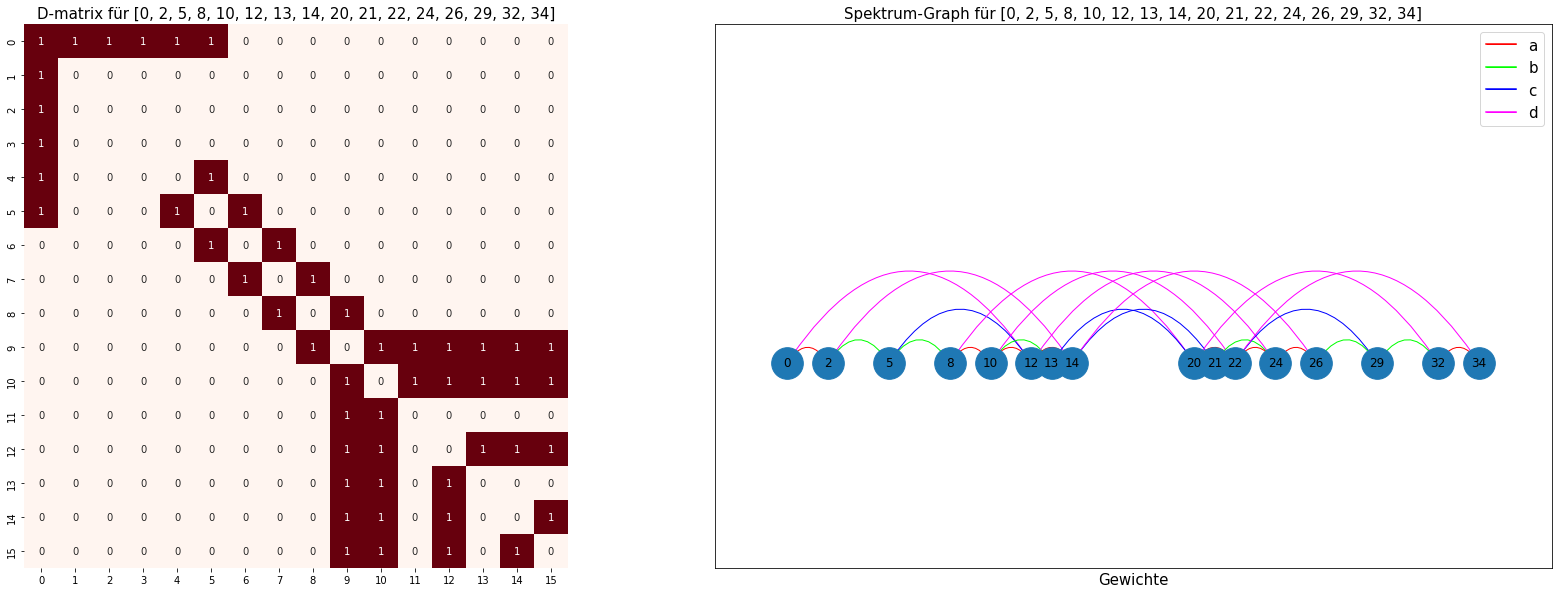

In [8]:
def kante_im_spektrum_graph(spektrum: list, μ: dict, i: int, j: int):
    '''
    Parameter:
        spektrum Liste mit Gewichtn
        μ        Gewichtsfunktion
        i        index einer masse im spektrum
        i        index einer masse im spektrum
    Returns:
        boolean: True  falls (v_i,u_j) Kante im Spektrum-Graph
                 False sonst
    Bemerkung: Implementierung benötigt O(|Σ|) statt O(1)
    '''
    return spektrum[j]-spektrum[i] in μ.values()

def generiere_D(spektrum: list, μ: dict):
    '''
    Parameter:
        spektrum Liste mit Gewichten
        μ        Gewichtsfunktion
    Returns:
        D-matrix
    '''
    D = [[-1 for j in range(len(spektrum))] for j in range(len(spektrum))]

    for i in range(len(spektrum)):
        for j in range(len(spektrum)):

            # Diagonale
            if (i==0 and j==0):
                D[i][j] = 1
            if (i==j and i>0):
                D[i][j] = 0
            # Nebendiagonale
            if (i==j+1):
                D[i][j] = max([D[l][j] for l in range(i) if kante_im_spektrum_graph(spektrum, μ, l, i)]+[0])
            if (j==i+1):
                D[i][j] = max([D[i][l] for l in range(j) if kante_im_spektrum_graph(spektrum, μ, l, j)]+[0])
            # Rest
            if (i-1>j):
                D[i][j] = int(kante_im_spektrum_graph(spektrum, μ, i-1, i)) * D[i-1][j]
            if (i<j-1):
                D[i][j] = int(kante_im_spektrum_graph(spektrum, μ, j-1, j)) * D[i][j-1]

    return D

############################################
#------------------------------------------#
μ        = μ_abcd
spektrum = generiere_spektrum('abbabcad', μ)
spektrum = generiere_spektrum('abbabcad', μ)
#------------------------------------------#
############################################

D = generiere_D(spektrum, μ)

# Plotting
fig, axes = pyplot.subplots(1,2,figsize=(30,10))
heatmap(D, ax=axes[0], annot=True, square = True, cbar=False, cmap='Reds')
axes[0].set_title(f'D-matrix für {spektrum}', fontsize=15)
axes[1].set_title(f'Spektrum-Graph für {spektrum}', fontsize=15)
spektrum_graph(axes[1], spektrum, μ, farben)
pyplot.subplots_adjust(wspace=0.)
pyplot.show()

### 2.3.3. Backtracing in D

Sei $D[n,j]=1$ für ein $j<n$ $\rightarrow$ Suffix-pfad von $x_0$ nach $x_j$ spiegeln zu Pfad zu Pfad  $y_j$ nach $y_0$<br>
Können wir diese Pfade "zusammenkleben"? Ja, wenn $x_0$ und $y_j$ durch eine Kante verbunden sind.<br>
Wir suchen eine Zelle der untersten Reihe, oder der rechtesten Spalte und beginnen dort ein Backtracing.

In [9]:
def vorgänger(D: list, spektrum: list, μ: dict, i: int, j: int):
    '''
    Returns:
        (tuple) Die Indizes der Vorgängerzelle von D[i,j]
    '''
    # Nebendiagonale
    if i==j+1:
        return (random.choice([l for l in range(i) if (kante_im_spektrum_graph(spektrum, μ, l, i) and bool(D[l][j]))]), j)
    if i+1==j:
        return (i, random.choice([l for l in range(j) if (kante_im_spektrum_graph(spektrum, μ, l, j) and bool(D[i][l]))]))
    # Rest
    if i>j+1:
        return (i-1, j)
    if j>i+1:
        return (i, j-1)
    
def backtracing_in_D(D: list, spektrum: list, μ: dict, μ_invers: dict, i: int, j: int):
    ''' 
    Returns:
        (tuple) Präfix und Suffix, die sich aus einem Backtracking durch D beginnend in D[i,j] ergeben können
    '''
    # Trvialer Fall
    if i==0 and j==0:
        return ('','')
    # Rekursion
    else:
        vorgänger_i, vorgänger_j = vorgänger(D, spektrum, μ, i, j)
        präfix, suffix  = backtracing_in_D(D, spektrum, μ, μ_invers, vorgänger_i, vorgänger_j)
        print(f'Aktuelle Zelle: D[{vorgänger_i},{vorgänger_j}]')
        print(f'präfix: {präfix}, suffix: {suffix}')
        # Fall 1: Erweiterung des Präfix
        if i>vorgänger_i:
            return (präfix + μ_invers[spektrum[i]-spektrum[vorgänger_i]], suffix)
        # Fall 2: Erweiterung des Suffix
        if j>vorgänger_j:
            return (präfix, suffix + μ_invers[spektrum[j]-spektrum[vorgänger_j]])

def startzelle(D):
    ''' 
    Returns:
        (tuple) Eine Zelle, von der aus das Backtracking gestartet werden kann
    ACHTUNG: Prüfung nach Existenz der Kante zwischen Präfixpfad und Suffixpfad fehlt bisher
    '''
    kandidaten = [(len(D)-i-1, i) for i in range(len(D))]
    kandidaten = [k for k in kandidaten if bool(D[k[0]][k[1]])]
    return random.choice(kandidaten)

############################################
#------------------------------------------#
μ        = μ_abcd
spektrum = generiere_spektrum('abbabcad', μ)
#------------------------------------------#
############################################

D = generiere_D(spektrum, μ)
start_i, start_j = startzelle(D)
präfix, suffix = backtracing_in_D(D ,spektrum, μ, invers(μ), start_i, start_j)
string = präfix+suffix[::-1]
print(f'Aktuelle Zelle: D[{start_i},{start_j}]')
print(f'präfix: {präfix}, suffix: {suffix}\n')
print(f'String: {string} oder {string[::-1]}')

Aktuelle Zelle: D[0,0]
präfix: , suffix: 
Aktuelle Zelle: D[0,1]
präfix: , suffix: a
Aktuelle Zelle: D[0,2]
präfix: , suffix: ab
Aktuelle Zelle: D[0,3]
präfix: , suffix: abb
Aktuelle Zelle: D[0,4]
präfix: , suffix: abba
Aktuelle Zelle: D[5,4]
präfix: d, suffix: abba
Aktuelle Zelle: D[5,6]
präfix: d, suffix: abbab
Aktuelle Zelle: D[7,6]
präfix: da, suffix: abbab
Aktuelle Zelle: D[7,8]
präfix: da, suffix: abbabc

String: dacbabba oder abbabcad


# 3 Peptid De novo Sequenzierung II<br>Rekonstruktion von Strings aus fehlerbehafteten MS-Daten mit dynamischer Programmierung

## 3.1 Algorithmus für zusätzliche Peaks

Wir suchen den String, bzw. Pfad, der die **meisten** Peaks im Spektrum erklärt<br>
$\rightarrow$ **Peak-Counting-Score**<br>
Aus dem Entscheidungsproblem des vorherihgen Kapitel wird ein Optimierungsproblem<br>
<br>

Wir definieren eine $nxn$-Matrix Q
$$
Q[i,j]:= 
\begin{aligned}
& Die~maximale~Anzahl~von~Peaks~in~einem~zulässigen~Paar~von~Pfaden,\\
& einem~Pfad~(Präfixpfad)~von~x_0~nach~x_i~und~einem~anderen~(Suffixpfad)~von~x_0~nach~x_j
\end{aligned}
$$

**Beobachtungen:**<br>
1. $Q[0,0]=0$<br>
Keine Peaks erklärt
2. $Q[i,i]=0$ für $i>0$<br>
Unmöglich
3. falls $i>j$ und $(x_l, x_i) \in E$: Wir können den Präfixpfad von $x_l$ nach $x_i$ verlängern
3. falls $j>i$ und $(x_l, x_j) \in E$: Wir können den Suffixpfad von $x_l$ nach $x_j$ verlängern

Außerdem:<br>
Gewichtung von Peaks zB. in Abhänigkeit von den Peak-Intensitäten möglich

In [10]:
def generiere_Q(spektrum: list, μ: dict):

    Q = [[-1 for j in range(len(spektrum))] for j in range(len(spektrum))]
    
    for i in range(len(spektrum)):
        for j in range(len(spektrum)):

            # Diagonale
            if (i==0 and j==0):
                Q[i][j] = int(0)
            if (i==j and i>0):
                Q[i][j] = float('-inf')
            # Rest
            if (i>j):
                Q[i][j] = int(max([Q[l][j]+int(kante_im_spektrum_graph(spektrum, μ, l, i)) for l in range(i)]+[0]))
            if (j>i):
                Q[i][j] = int(max([Q[i][l]+int(kante_im_spektrum_graph(spektrum, μ, l, j)) for l in range(j)]+[0]))

    return Q

#########################
#-----------------------#
μ           = μ_abcd 
string      = 'abbabcad'
extra_peaks = [36, 6, 19]
#-----------------------#
#########################

spektrum = generiere_spektrum(string, μ) + extra_peaks
spektrum.sort()
Q = generiere_Q(spektrum, μ)
display(DataFrame(Q))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0,1.0,2.0,2.0,3.0,4.0,5.0,5.0,6.0,6.0,6.0,7.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
1,1,-inf,1.0,1.0,2.0,3.0,4.0,4.0,5.0,5.0,5.0,6.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
2,2,1.0,-inf,2.0,3.0,4.0,5.0,5.0,6.0,6.0,6.0,7.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
3,2,1.0,2.0,-inf,3.0,4.0,5.0,5.0,6.0,6.0,6.0,7.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
4,3,2.0,3.0,3.0,-inf,3.0,4.0,4.0,5.0,5.0,5.0,6.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
5,4,3.0,4.0,4.0,3.0,-inf,5.0,5.0,6.0,6.0,6.0,7.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
6,5,4.0,5.0,5.0,4.0,5.0,-inf,6.0,6.0,6.0,7.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0
7,5,4.0,5.0,5.0,4.0,5.0,6.0,-inf,7.0,7.0,7.0,8.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0
8,6,5.0,6.0,6.0,5.0,6.0,6.0,7.0,-inf,7.0,8.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0
9,6,5.0,6.0,6.0,5.0,6.0,6.0,7.0,7.0,-inf,8.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0


## 3.2. Verlorene Peaks

**1. Nur Präfix- oder Suffixpeaks gehen verloren:**

$\rightarrow$ Spektrum spiegeln<br>
$M':=M\cup \{max(M)-m:m \in M\}$<br>
<br>
$
w[x,y]= 
\left\{
\begin{aligned}
& 0 & falls~ y\notin M~und~y\notin M'\\
& 1 & falls~entweder~y\in M~oder~y\in M'\\
& 2 & falls~y\in M~und~y\in M'
\end{aligned}
\right.
$

**2. Präfix- und Suffix-peaks gehen verloren**

Wir können vermutete Peaks ergänzen. (Zb. Wenn es zwei Peaks mit Massen $m_1,m_2$ und ein Paar von Buchstaben $m_1,m_2$ gibt, sodass $|m_1-m_2|=\mu(s_1)+\mu(s_2)$ )<br>
Schwierigkeiten:
- Wir können Reihenfolge von 2 oder mehr Aminosäuren nicht auseinanderhalten
- $\mu(Q)=\mu(A)+\mu(G)$


## 3.3 Präfixmasse $\neq$ Suffixmasse

Aufhebung einer künstlichen Bedingung, die eingeführt wurde um Peak-Double-Counting zu vehindern.

Wir definieren eine $nxn$-Matrix Q'
$$
Q'[i,j]:= 
\begin{aligned}
& Die~maximale~Anzahl~von~Peaks~in~einem~zulässigen~Paar~von~Pfaden,\\
& einem~Pfad~(Präfixpfad)~von~x_0~nach~x_i~und~einem~anderen~(Suffixpfad)~von~x_0~nach~x_j\\
& Wir~erlauben~Präfixmasse=Suffixmasse,~Suffixpfad~und~Präfixpfad~müssen~also~nicht~knotendisjunkt~sein\\
& Erklärte~Massen~werden~dabei~nur~einmal~gezählt
\end{aligned}
$$


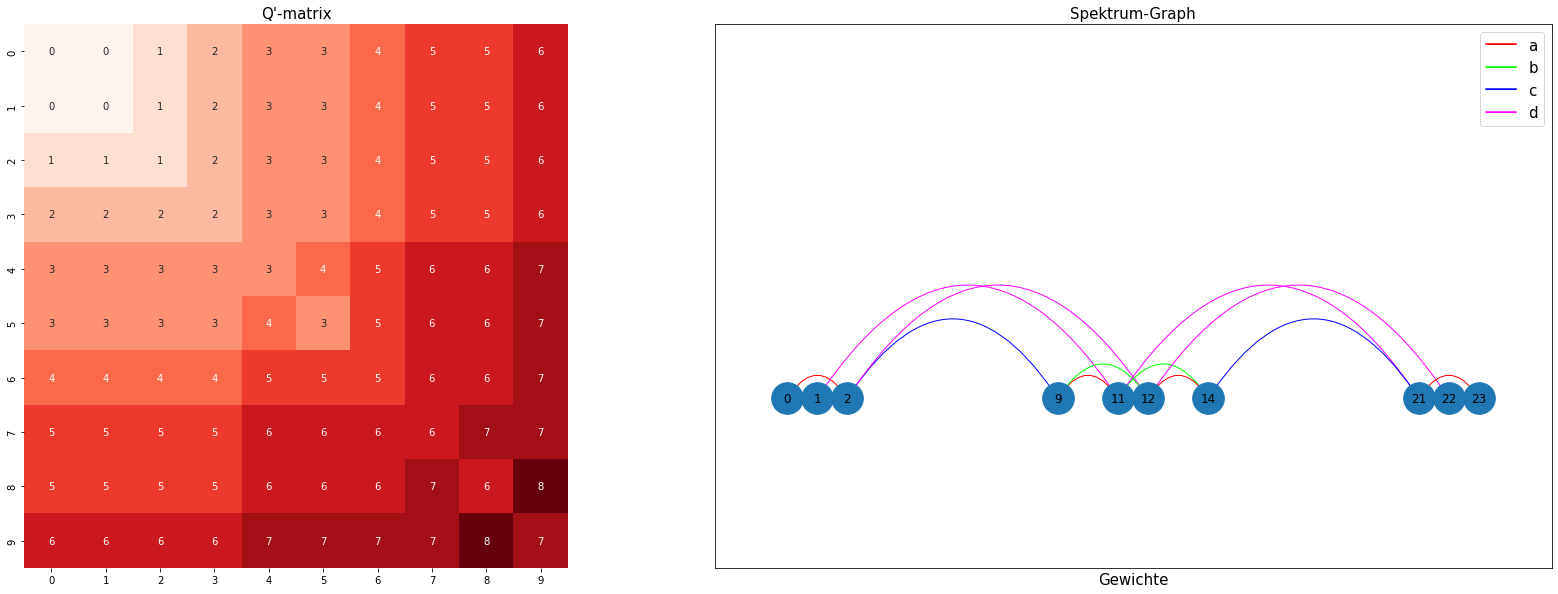

In [11]:
def generiere_Q_(spektrum: list, μ: dict):

    Q_ = [[-1 for j in range(len(spektrum))] for j in range(len(spektrum))]
    
    for i in range(len(spektrum)):
        for j in range(len(spektrum)):

            # Diagonale
            if (i==0 and j==0):
                Q_[i][j] = 0
            if (i==j and i>0):
                Q_[i][j] = max([Q_[l][j] for l in range(i) if kante_im_spektrum_graph(spektrum, μ, l, i)]+[Q_[i][l] for l in range(j) if kante_im_spektrum_graph(spektrum, μ, l, j)]+[0])
            # Rest
            if (i>j):
                Q_[i][j] = max([Q_[l][j]+int(kante_im_spektrum_graph(spektrum, μ, l, i)) for l in range(i)]+[0])
            if (j>i):
                Q_[i][j] = max([Q_[i][l]+int(kante_im_spektrum_graph(spektrum, μ, l, j)) for l in range(j)]+[0])

    return Q_

##############################################
#--------------------------------------------#
μ        = {'a':2,'b':3,'c':7,'d':10}
spektrum = [0, 1, 2, 9, 11, 12, 14, 21, 22, 23]
#--------------------------------------------#
##############################################

Q_ = generiere_Q_(spektrum, μ)

# Plotting
fig, axes = pyplot.subplots(1,2,figsize=(30,10))
heatmap(Q_, ax=axes[0], annot=True, square = True, cbar=False, cmap='Reds')
spektrum_graph(axes[1], spektrum, μ, farben)
axes[0].set_title(f'Q\'-matrix', fontsize=15)
axes[1].set_title(f'Spektrum-Graph', fontsize=15)
pyplot.subplots_adjust(wspace=0.)
pyplot.show()

# 4 Kombinatorik gewichteter Strings

## 4.1 Was sind Kompomere

\begin{align*}
& (\Sigma = \{a_1, a_2, ..., a_k\},~\mu:\Sigma\rightarrow\mathbb{R}) & gewichtetes~Alphabet\\
& \mu(s=s_1,...,s_n)=\sum_{i=1}^{n}\mu(s_i) & Gewicht~eines~Strings
\end{align*}

Beobachtung: Reihenfolge irrelevant für das Gewicht eines Strings, nur die Buchstabenhäufigkeit entscheidet.

**Kompomer** über $\Sigma$ ist ein Vektor $c=(c_1,...,c_k)^T\in\mathbb{N}^k$<br>
Funktion **comp** $:= \Sigma^{*} \rightarrow \mathbb{N}^k$ bildet Strings s auf ihr Kompomer $comp(s)=(c_1,...,c_k)^T$ mit $c_j=|\{1\leq i\leq |s|: s_i=a_i \}|$ ab. (Wir zählen alle Buchstaben)<br>

Länge $|c|=\Sigma_{j=1}^{k}c_j$<br>
Gewicht $\mu(c)=\Sigma_{j=1}^{k}c_j*\mu(a_j)$

**Lemma:**<br>
Gegeben $s\in\Sigma^*$, Kompomer c über $\Sigma$ mit $c=comp(s)$ $\Rightarrow$ $|c|=|s|$ und $\mu(c)=\mu(s)$

## 4.2 Anzahl der Kompomere mit Länge n

**Lemma:**

$Anzahl~der~Kompomere~mit~Länge~n=\binom{n+k-1}{k-1}$

Beweis durch bijektive Abbildung von n+k-1 Punkte in einer Reihe und Auswahl von k-1 solcher Punkte
<img src="Abbildungen\Kompomere.png" style="width: 50%"><br>
Abb 6: Beweisidee für die Anzahl der Kompomere

## 4.3 Vier Probleme

1. Gibt es ein Kompomer mit Masse M?
2. Wieviele Kompomere mit Masse M gibt es?
3. Finde ein Kompomer mit Masse!
4. Finde alle Kompomere mit Masse M!

Komplexität der DP-Lösungen aus diesem Abschnitt ist jeweils nur **pseudopolynomiell**.<br>
Es ist kein effizienter Algorithmus zur Berechnung der Anzahl an Zerlegungen (Problem 2) bekannt, aber es gibt Approximationen.<br> Für Problem 1 werden wir uns einen effizienten polynomzeit Alorithmus ansehen

### 4.3.1 Lösung für Problem 2: Wieviele Kompomere mit Masse M gibt es?

Wir definieren eine $nxn$-Matrix C
$$
C[i,m]:= 
\begin{aligned}
& \#~Kompomere~aus~Buchstaben~\Sigma'=\{a_1,...,a_i\}~mit~Masse~j
\end{aligned}
$$

Initialisierung:<br>
$C[0,0]=1$<br>
$C[0,m]=0$ (für $m>0$)<br>
Rekurrenz:<br>
$
C[i,m]= 
\left\{
\begin{aligned}
& C[i,m]=C[i-1,m]+C[i,m-a_i] & falls~m\geq a_i\\
& C[i,m]=C[i-1,m] & sonst
\end{aligned}
\right.
$

In [12]:
def generiere_C(μ: dict, M: int):

    C = [[-1 for m in range(M+1)] for i in range(len(μ)+1)]
    gewichte = [0]+sorted(μ.values())

    for i in range(len(gewichte)):
        for m in range(M+1):

            if (i==0 and m==0):
                C[i][m] = 1
            if (i==0 and m>0):
                C[i][m] = 0
            if (i>0):
                if (m < gewichte[i]):
                    C[i][m] = C[i-1][m]
                else:
                    C[i][m] = C[i-1][m] + C[i][m-gewichte[i]] 
            
    return C

##############################
#----------------------------#
μ = {'a':2,'b':3,'c':7,'d':10}
m = 13
#----------------------------#
##############################

C = DataFrame(generiere_C(μ, m))

# Display
display(concat([DataFrame({'Gewichte':[0]+sorted(μ.values())}),C], axis=1))

,Gewichte,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,1,0,1,0,1,0,1,0,1,0,1,0,1,0
2,3,1,0,1,1,1,1,2,1,2,2,2,2,3,2
3,7,1,0,1,1,1,1,2,2,2,3,3,3,4,4
4,10,1,0,1,1,1,1,2,2,2,3,4,3,5,5


### 4.3.2. Problem 1: Gibt es ein Kompomer?

Wir definieren eine $1xn$-Matrix B
$$
B[m]:=
\left\{
\begin{aligned}
& 1 & falls~m~zerlegbar~über~\Sigma=\{a_1,...,a_n\}\\
& 0 & sonst
\end{aligned}
\right.
$$

Initialisierung:<br>
$B[m]=1$<br>
Rekurrenz:<br>
$
B[m]=
\left\{
\begin{aligned}
& 1 & falls~\exists~i: m>a_i, B[m-a_i]=1\\
& 0 & sonst
\end{aligned}
\right.
$

### 4.3.3. Problem 4: Finde alle Kompomere mit Masse M

Backtracking in C

### 4.3.4 Problem 3: Finde ein Kompomer mit Masse M

Backtracing in B

## 4.4 Round-Robin Algorithmus, "ist M zerlegbar?"

**Money Changing Problem**<br>

**Lemma:**<br>
Falls $ggT(a_1,...,a_n)=1$, dann gibt es eine Zahl g, sodass alle Zahlen $g+1,g+2,...~$ über $\Sigma=\{a_1,...,a_n\}$ zerlegbar sind. Die kleinste solche Zahl nennen wir **Frobeniuszahl** des Problems.<br>

### 4.4.1. Restklassentabellen

Beobachtung: Falls $M$ zerlegbar, dann ist auch $M+a_i$ zerlegbar<br>

Für $r=0,...,a_1-1$ sei $N[r]$ die kleinste über $\Sigma=(a_1,...,a_n)$ zerlegbare Zahl, sodass $N[r] \mod a_1 = a_1$ (Restklsse R)<br>
Die Zahlen $N[0],...,N[a_1-1]$ bilden die Restklassentabelle.<br>

Was können wir mit der Restklassentabelle tun?
1. "Ist M zerlegbar?" in konstanter Zeit beantworten
2. Die Frobeniuszahl berechnen ($g=max(\{N[r]\})-a_1$)

### 4.4.2. Iterative Berechnung der Restklassentabelle

Wir berechnen $N[r]$ iterativ für Teilprobleme $\Sigma'=\{a_1,...,a_i\}$ für $i=1,...,k$<br>

Für $i=1:~\begin{aligned} & N[0]=0 \\ & N[r]=\infty~für~r>0 &\end{aligned}$<br>

Angenommen wir kennen Werte $N'[r]$ für das Problem $\{a_1,...,a_{i-1}\}$, dann können wir die Werte $N[r]$ daraus berechnen.<br>
$n \leftarrow 0$<br>
$While~True:$<br>
$~~~~n \leftarrow n + a_i$<br>
$~~~~r \leftarrow n~mod~a_1$<br>
$~~~~n \leftarrow min(\{n, N'[r]\})$<br>
$~~~~N[r] \leftarrow n$<br>
$~~~~If~r=0:$<br>
$~~~~~~~~Break$<br>

In [13]:
def generiere_ERT(a):
    '''
    Parameter:
        a (list), Liste von Gewichten
    Returns:
        (pandas.DataFrame) Erweiterte Restklassentabelle für a
    '''
    ERT = [[0 for j in range(len(a))] for i in range(a[0])]
    # Spalte für a_1
    for r in range(1, a[0]):
        ERT[r][0] = float('inf')
    # Alle weiteren Spalten
    for i in range(1, len(a)):
        # Initilalisierung
        n = 0
        # Schritt
        while True:
            n = n + a[i]
            r = n % a[0]
            n = min([n, ERT[r][i-1]])
            ERT[r][i] = n
            if n==0:
                break
    # Konversion in ansehnlichen Datenrahmen
    ERT = DataFrame(ERT).rename(columns = {i:gewicht for i, gewicht in enumerate(a)}, inplace = False)
    return ERT

a = [5,8,9,12]
ERT = generiere_ERT(a)
display(ERT)

,5,8,9,12
0,0.0,0,0,0
1,inf,16,16,16
2,inf,32,17,12
3,inf,8,8,8
4,inf,24,9,9


# 5 Datenbanksuche

Suche von gemessenen Spektren in Datenbank von Referenzspektren bekannter Identität

Datenbank meist implizit $\rightarrow$ wird "on the fly" erzeugt

Leitfragen:
1. Welches Referenzspektrum passt am besten zum gemessenen Spektrum
2. Wie sicher sind wir, dass dieses das "Richtige" ist?

## 5.1. Abstandsfunktionen

### 5.1.1. Skalarprodukt

$<x,y>=\Sigma_ix_iy_i$<br>
<br>
$||x||^2=<x,x>=\Sigma_ix_ix_i$ (normierte Spektren)<br>

für unit-mass accuracy

### 5.1.2. Skalarprodukt für stetige Funktionen

Für hochauflösende Massenspektometrie

**Idealisierung der Daten**<br>
Darstellung von Peaks durch Normalverteilungen<br>

**Skalarprodukt mit Integral**<br>
$<x,y>=\int f(m)g(m)~dm$

### 5.1.3 Peak-Counting-Score

Idee: Gemeinsame Peaks zählen

Probleme:
- **Massenabweichung**, wir müssen maximale Massenabweichung $\delta >0$ festlegen.
- **Wann zählt ein Peak?** Wir müssen einen Schwellwert für das Peak-Picking festlegen
- **Bevorzugung von Langen Spektren**, mit mehr Peaks steigt die Wahrscheinlichkeit, dass Spektren einen hohen Score bekommen, aber sind sie deswegen besser?

**Peak-Counting-Score**<br><br>
Funktion $MxM \rightarrow \mathbb{R}$<br>
Vernünftig: globale Peak-Scoring-Funktion $peak~x~peak:\rightarrow\mathbb{R}$
<br>
Wir können unser Wissen über Massenspektometrie nutzen und stochastische Modelle integrieren
- **Peak-Intensität**<br>log-odds-score<br>a) mit Exponentialverteilung<br>b) mit Paretoverteilung (besser) 
- **Normalverteilungsannahme für Massendifferenzen**<br>kontinuierliche Gewichtungsfunktion über p-Values<br>
- Bekannte **Massengenauigkeiten** für Geräte

## 5.2 Signifikanz, p-values

Zentrale Frage:

Wie wahrscheinlich ist es, dass aus einem Vergleich von einem gemessenem Spektrum mit einem zufälligen Referenzspektrum einen Score $T\geq x$ resultiert?

### 5.2.1. Naiver-Ansatz

Erzeuge viele (zB. eine Millionen) zufällige geeignete Referenzspektren, vergleiche alle mit dem gemessenen Spektrum und zähle wie häufig Scores $T'\geq T$ berechnet werden<br>

**Was sind geeignetee Referenzpektren?**<br>
Rein zufällige Peak-Intensitäten? Nein, denn so erzeugen wir auch Spektren, die so nie gemessen werden können $\rightarrow$ Signifikanzüberschätzung
Wissen über die Anwendung einfließen lassen! Spektren von zufällig generierten Strings mit gleicher Muttermasse.

### 5.2.2. Verteilungsparameter schätzen

Scores folgen einer Wahrscheinlichkeitsverteilung, deren Parameter jeweils vom gemessenen Spektrum abhängt.<br>
Um die Parameter schätzen können brauchen wir das gemessene Spektrum mit viel weniger (mehr als 1000-mal) Refernzspektren zu vergleichen.<br>

Berchnung der Parameter durch Schätzung der Momente oder besser durch Maximum-likelihoodschätzer

Anmerkung: Es ist besonders wichtig, dass die Schätzungen für kleine p-Values gut sind. Ob ein p-Value 0,2 oder 0,6 ist ist eigentlich egal, da beides als nicht signifikant angesehen wird.

### 5.2.3. Korrigieren für multiples Testen

Treffer ist einer von n Kandidaten

- E-value (Erwartete Anzahl von Treffern) n*p

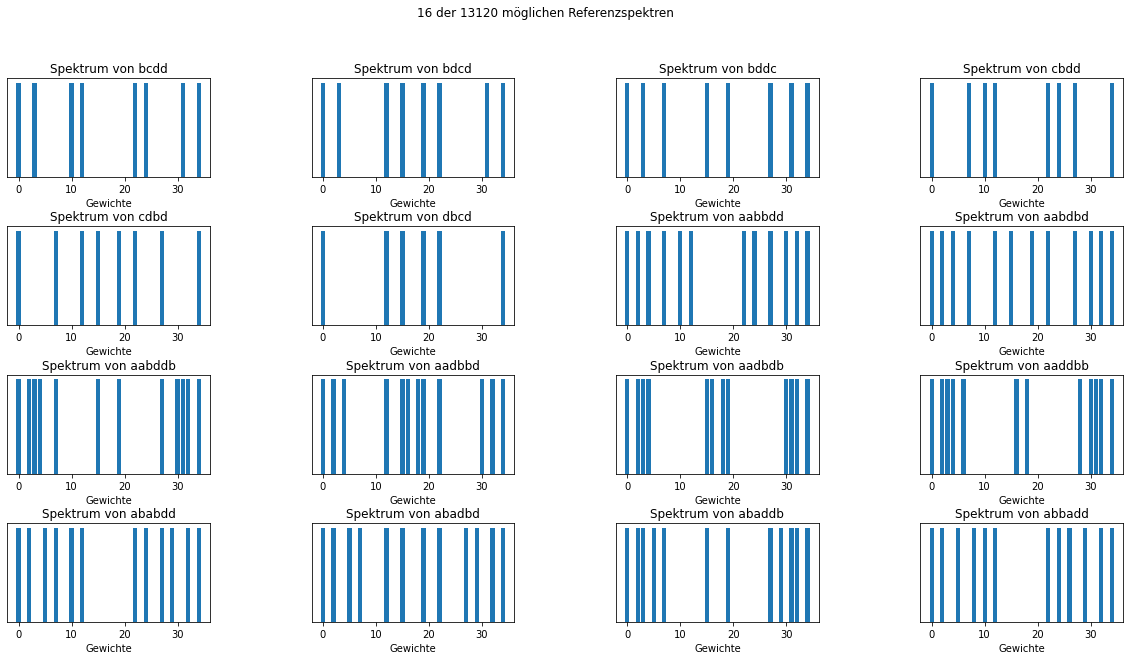

In [14]:
# Idee 1 (naiv, MC-Simulation)
# Idee 2 (Verteilungsschätzung)
# Was wir brauchen:
# 1. Erzeugung von Referenzspektren
#    Generiere alle Strings mit gleicher Muttermasse Branch-and-Bound-Algorithmus (Hinweis: anderes Notebook enthält schöne Visualisierung).
#    Daraus, oder nur von einer Auswahl simulieren wir die idealen Spektren
# 2. Eine Score-funktion.
#    Wir verwenden eine sehr einfache Bewertungsfunktion:
#    Gemeinsame Peaks, oder kein Peak in beiden Spektren geben +1 
#    Peaks nur in einem Spektrum geben -1
# Bemerkung: Keine Wahrscheinlichkeitsgewichtung der Referenzspektren, alle werden als gleich wahrscheinlich angesehen

def branch_and_bound(μ: dict, n: int, m: int):
    '''
    Rekursive Berechnung von Strings mit Masse m für Datenbank

    Parameter:
        μ Gewichtsfunktion
        n maximale Länge
        m Zielgewicht für die String
        dict, n: int, m: int

    Returns:
        (list) Liste von Strings, die wir für eine Referenzdatenbank brauchen

    Idee:
    Angenommen wir kennen für n alle Strings s2 der Länge n-2 oder kürzer mit μ(s2)=m und alle Strings s1 der Länge Länge n-1 mit μ(s2)≤m
    Wir behalten davon natürlich alle Strings s mit μ(s)=m.
    Die Strings s mit μ(s)<m werden entweder um die Buchstaben a erweitert, sodass μ(s)+a≤m oder verworfen, falls es keine solche Buchstaben gibt
    '''
    # Trivialer Fall n = 1
    if n == 1:
        return list(μ.items())

    # Rekursion für n > 1
    n_1 = branch_and_bound(μ, n-1, m)
    n_1 = [string for string in n_1 if not ((len(string[0])<n-1) and (string[1]<m))]
    n   = [(string[0] + buchstabe, string[1]+μ[buchstabe]) for string in n_1 for buchstabe in μ.keys() if (len(string[0])==n-1) and (string[1]+μ[buchstabe]<=m)]
    
    return n_1 + n

def entferne_reverse_duplikate(strings):
    '''
    Entfernt reversen Strings aus der Eingabeliste.
    
    Parameter:
        strings (list): Eine Liste von Strings.
    
    Returns:
        list: Eine Liste von Strings ohne reverse Duplikate
    '''
    result = []
    for s in strings:
        if s not in result and s[::-1] not in result and s != s[::-1]:
            result.append(s)
    return result

def generiere_referenz_strings(μ: dict, m: int):
    '''
    Generiert eine Datenbank mit allen Strings mit Gewicht m
    '''
    maximale_länge = int(m/min(μ.values()))
    strings_mit_maximalem_gewicht_m = branch_and_bound(μ, maximale_länge, m)
    strings_mit_gewicht_m = [s[0] for s in strings_mit_maximalem_gewicht_m if s[1]==m]
    datenbank = entferne_reverse_duplikate(strings_mit_gewicht_m)
    return datenbank

def generiere_referenz_spektren(μ: dict, m: int):
    '''
    Generiert eine Datenbank mit allen Spektren, die von Strings mit Gewicht m erzeugt werden
    '''
    string_datenbank   = generiere_referenz_strings(μ, m)
    spektrum_datenbank = [(generiere_spektrum(string, μ), string) for string in string_datenbank]
    return spektrum_datenbank

##############################
#----------------------------#
μ = μ_abcd
m = 34
#----------------------------#
##############################

referenzspektren = generiere_referenz_spektren(μ, m)

# Plotting
n = min([int(math.sqrt(len(referenzspektren))), 4])
fig, axes = pyplot.subplots(n, n, figsize=(20,10))
for i in range(n):
    for j in range(n):
        plot_spektum(axes[i][j], referenzspektren[i*n+j][0])
        axes[i][j].set_title(f'Spektrum von {referenzspektren[i*n+j][1]}')
pyplot.suptitle(f'{n*n} der {len(referenzspektren)} möglichen Referenzspektren ')
pyplot.subplots_adjust(hspace=0.5, wspace=0.5)
pyplot.show()

C:\Users\simon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


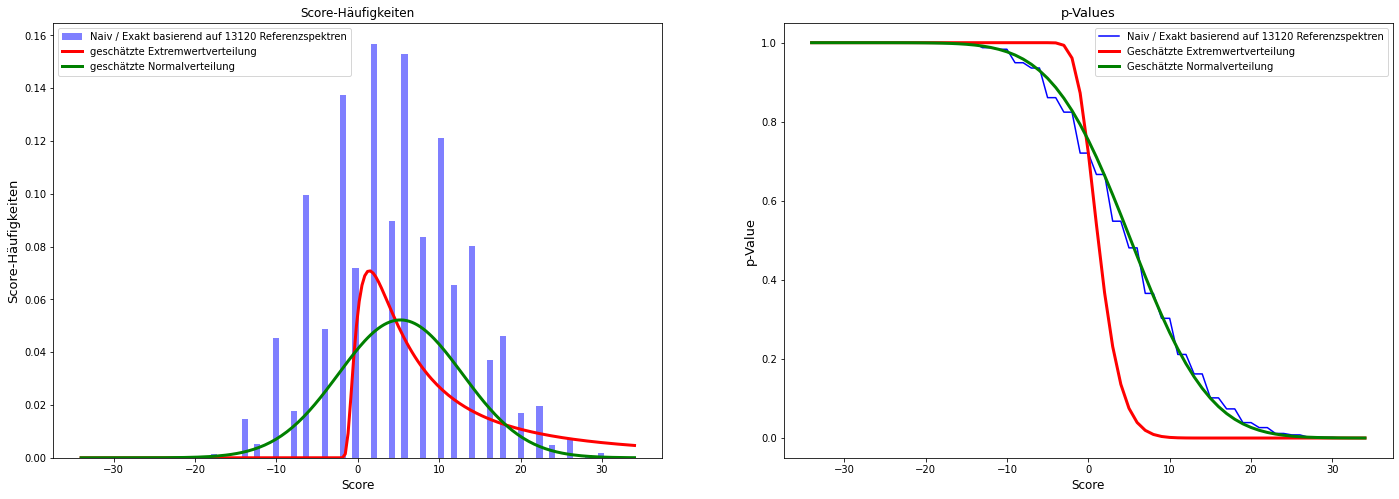

In [15]:
def score(spektrum_1, spektrum_2):
    # Konversion der Darstellung der Spektren in binäre Listen 
    spektrum_1 = [i in spektrum_1 for i in range(spektrum_1[len(spektrum_1)-1])]
    spektrum_2 = [i in spektrum_2 for i in range(spektrum_2[len(spektrum_2)-1])]
    # Score berechnen
    gemeinsame_peaks       = [(spektrum_1[i] and spektrum_2[i]) for i in range(len(spektrum_1))]
    nicht_gemeinsame_peaks = [not (spektrum_1[i] or spektrum_2[i]) for i in range(len(spektrum_1))]
    individuelle_peaks     = [(spektrum_1[i]^spektrum_2[i]) for i in range(len(spektrum_1))]
    return sum(gemeinsame_peaks) + sum(nicht_gemeinsame_peaks) -  sum(individuelle_peaks)

def log_likelihood(params, data):
    loc, scale = params
    return -numpy.sum(genextreme.logpdf(data, loc=loc, c=-1, scale=scale))

######################################################
# ACHTUNG:                                           #
# Laufzeit steigt sehr schnell mit der Muttermasse   #
# da wir immer alle möglichen Strings erzeugen und   #
# dafür viel Zeit brauchen                           #
#----------------------------------------------------#
μ = μ_abcd
gemessenes_spektrum = generiere_spektrum('abbabcad',μ)  
n = 100
#----------------------------------------------------#
######################################################

# Erzeugung der Referenzspektren
muttermasse       = gemessenes_spektrum[len(gemessenes_spektrum)-1]
referenz_spektren = [s[0] for s in generiere_referenz_spektren(μ, muttermasse)]
mögliche_scores   = [-(muttermasse-i) for i in range(muttermasse)]+[i for i in range(muttermasse+1)]

# 1. Naiv
referenz_scores = referenz_scores = list(map(lambda s: score(gemessenes_spektrum, s), referenz_spektren))
p_values_naiv   = list(map(lambda T: sum([1 if (t >= T) else 0 for t in referenz_scores ])/len(referenz_scores), mögliche_scores))

# 2. Verteilungsschäzung (Extremwertverteilung)
referenz_scores_auswahl = random.sample(referenz_scores, n)
# 2.1. Extremwertverteilung
initial_guess = [numpy.mean(referenz_scores_auswahl), numpy.std(referenz_scores_auswahl)]
result = minimize(log_likelihood, initial_guess, args=(referenz_scores,))
loc, scale = result.x
extremwertverteilung = genextreme(0.1, loc=0.5, scale=2)
p_values_extrem = [1-quad(lambda x: extremwertverteilung.pdf(x), mögliche_scores[0], T)[0] for T in mögliche_scores]
# 2.2. Normalverteilung
mu, sigma = norm.fit(referenz_scores_auswahl)
p_values_normal = [1-quad(lambda x: norm.pdf(x, mu, sigma), mögliche_scores[0], T)[0] for T in mögliche_scores]

# 3. Plotting
fig, axes = pyplot.subplots(1,2,figsize=(24,8))
# 3.1. Häufigkeiten
x = numpy.linspace(min(mögliche_scores), max(mögliche_scores), 200)
axes[0].hist(referenz_scores, density=True, bins=len(mögliche_scores), label=f'Naiv / Exakt basierend auf {len(referenz_spektren)} Referenzspektren', color='blue', rwidth=2, alpha=0.5)
axes[0].plot(x, genextreme.pdf(x, loc=loc, c=-1, scale=scale), label='geschätzte Extremwertverteilung', color='red', linewidth=3)
axes[0].plot(x, norm.pdf(x, mu, sigma), label='geschätzte Normalverteilung', color='green', linewidth=3)
axes[0].set_xlabel('Score', fontsize=12)
axes[0].set_ylabel('Score-Häufigkeiten', fontsize=13)
axes[0].set_title('Score-Häufigkeiten')
axes[0].legend()
# 3.2. p-Values
axes[1].plot(mögliche_scores, p_values_naiv, label=f'Naiv / Exakt basierend auf {len(referenz_spektren)} Referenzspektren', color='blue')
axes[1].plot(mögliche_scores, p_values_extrem, label='Geschätzte Extremwertverteilung', color='red', linewidth=3)
axes[1].plot(mögliche_scores, p_values_normal, label='Geschätzte Normalverteilung', color='green', linewidth=3)
axes[1].set_xlabel('Score', fontsize=12)
axes[1].set_ylabel('p-Value', fontsize=13)
axes[1].set_title('p-Values', fontsize=13)
axes[1].legend(fontsize=10)
pyplot.subplots_adjust(wspace=0.2)
pyplot.show()


## 5.3. Signifikanz, Köderdatenbanken und False-Discovery-Rate

### 5.3.2 False-Discovery-Rate und q-Values

Treffer mit hohen Scores sind häufiger richtig, als solche mit niedrigerem Score

Sortiere die Kandidaten nach ihrem Score und wähle die n ersten in der Liste aus. Was wäre eine gute Wahl eines Score-Threshold bzw n?

False-Discovery-Rate: $FDR:=\frac{FP}{FP+TP}$<br>
<br>
q-Value: minimale FDR, sodass ein Treffer noch ausgewählt wird (wird einem Treffer zugeördnet, hängt aber von der gesamten Trefferliste ab)<br>
<br>
Schätzung aus kleiner Stichprobe

### 5.3.2 Köderdatenbanken

Annahme: Falsche Treffer sind Zufallstreffer?

Idee: Köderdatenbank (KDB) mit "falschen Peptiden", **Target-Decoy-Competition** Wir suchen in Datenbank und Köderdatenbank gemeinsam. Treffer sind entweder aus der ursprünglichen, oder aus der Köderdatenbank.

Anforderungen an Köderatenbanken:
1. $KDB \cap DB = \varnothing$ (Zumindest ungefähr)
2. Treffer in der KDB sind immer falsch
3. Falscher Treffer in DB ist so wahrscheinlich wie falscher Treffer in DB<br>Daher $|KDB|=|DB|$ sinnvoll (oder Korrektur)

Ideen für Köderdatenbbanken:
1. Zufällige Peptidsequenzen durch iid-Verteilung<br>Nachteil: Laufzeit, unrealistische Peptide
2. Inverse DB-peptide<br>Vorteil: Einfach, |KDB|=|DB|<br>Nachteil: Peaks von K und R vor Trypsinschnitten führen zu systematischer Benachteiligung der KDB
3. Pseudoinverse DB-peptide (nur erste n-1 Positionen werden invertiert)
4. Permutation der ersten n-1 Positionen

3 und 4 in der Praxis. Wegen der Größe des Raumes der Proteine sind die Anforderungen hier erfüllt

# 6 Isotopenmuster

- Metabolomik (Kleine Moleküle)
- Summenformeln
- Isotope
- Nominalmasse ($\# Protonen + \# Neutronen$)
- Monoisotopische Masse
- Isotopologe
- Isotopenverteilung, Simulation
- DB-Suche (DB wird "on-the-Fly"erzeugt)
- Wir können Peak-Intensitäten nicht trauen.

# 7 Fragmentierungsbäume

**Tandem-MS für Metabolite**<br>

Nachteile gegenüber Tandem-MS für Peptide:
- Weniger Restriktionen in der Struktur
- Datenbanken unvollständiger
- Gelegentlich sehr wenige Fragmentpeaks
- Schwer

Vorteile gegenüber Tandem-MS für Peptide:
- Reproduzierbarkeit von Spektren

Wir suchen zunächst nur nach Summenformeln, Strukturen sind zu kompliziert.<br>

Ermittle iterativ Scores für alle Summenformeln (Kandidaten) mit Masse~Muttermasse.
Für jeden Kandidaten bestimmen wir alle Zerlegungen der Fragmentpeaks, sodass die Zerlegungen **Teilsummenformeln** der Kandidatensummenforfmel ist.

## 7.1 (Gefärbter) Fragmentgraph

$G=(V,E)$<br>
$V := Menge~der~Zerlegungen~der~Peaks,~gefärbt~nach~ihrem~jeweiligen~Peak$<br>
$E := \{(u,v) : v \subsetneq u\}$ (v stammt möglicherweise von u ab)

<div style="display:flex; align-items:flex-end;">
    <div style="width:45%; margin-right:5%">
        <img src="Abbildungen\Fragmentierung.png" style="display: block; width: 75%; margin-bottom: 0;">
        <p>Abb 7: Fragmentierung erfolgt oft in mehreren Schritten</p>
    </div>
    <div style="width:45%">
        <img src="Abbildungen\Fragmentierungsgraph.png" style="display: block; width: 75%; margin-bottom: 0;">
    <p>Abb 8: Beispielhaftes Massenspektrum mit Fragmentierungsgraph</p>
    </div>
</div>

## 7.2 Maximaler farbenfroher Teilbaum Problem

Zwei Beobachtungen:
1. Es ist möglich, dass zu einem Fragmentpeak mehrere Fragmente gehören. Es ist auch möglich aber sehr unwahrscheinlich, dass sogar mehrere Summenformeln zu einem Fragmentpeak gehören.
2. Es ist möglich, dass ein und dasselbe Fragment durch unterschiedliche Fragmentierungsprozesse gebiltet wird. Dies ist aber eine seltene Ausnahme.
Aus Beobachtung 2 folgt: Wir suchen einen Baum im Fragmentgraphen
Aus Beobachtung 1 folgt: Der Baum soll **farbenfroh** sein, also soll jede Farbe maximal einmal vorkommen

Formelle Problemstellung:<br>
Gegeben: Fragmentierungsgraph<br>
Gesucht: farbenfroher Teilbaum mit maximalem Gewicht

Anmerkungen:
1. Magie in den Kantengewichten (Unser Wissen über Spektren)
2. Das ist ein Maximum-Aposteriori-Schätzer
3. Problem NP-schwer (Praxisfälle meist gutartig)

Wie Lösen wir dieses NP-schwere Problem? Erste Ansätze:
1. Approximation (schlecht, ebenfalls NP-schwer)
2. Problem vereinfachen<br>a) Farben weglassen<br>b) Kantengewichte $\geq 0$<br>Totzdem jeweils NP-schwer, beides zusammen nur P-schwer (maximalen Spannbaum finden), aber schlechte Ergebnisse
3. Standartheuristiken (Greedy etc) schlecht
4. Critical-Path-Heuristik (sehr gut um korrekte Summenformel zu finden)

### 7.2.1. FPT, Festparameter-Algorithmik

Beobachtung: G ist **azyklisch**

Wir definieren eine $nxn$-Matrix D
$$
D[v,S]:= das~maximale~Gewicht~eines~farbenfrohen~Teilbaums~der~in~v~wurzelt~und~eine~Teilmenge~der~Farben~in~S~verwendet
$$

Rekurrenz:
$
D[u,S]=max(
\left\{
\begin{aligned}
& max(\{D[v, S\backslash\{c(u)\}]+w(u,v)\})\\
& max(\{D[u, S_1]+D[u, S_2]: S_1 \cap S_2 = \c(u)\}\})\\
\end{aligned}
\right\}
)
$

<img src="Abbildungen/FPT.png"  style="width: 50%"><br>
Abb 9: Visualisierung für die zwei Fälle in der Rekurrenz zur Berechnung der Matrix D<br>

Klappt gut für ein dutzend Peaks, mit Tricks etwas mehr

### 7.3 Linear Integer Programming

# 8 Suche in Metabolit-Datenbanken

## Quellen

### Inhalt

Vorlesungen und zugehöriges Lehrmaterial von Prof. Dr. Sebastian Böcker<br>
https://bio.informatik.uni-jena.de/lehre/winter-22-23/algorithmische-massenspektrometrie/#more-8951

### Bilder

**0 Einführung**
1. Abb 1: https://daten.didaktikchemie.uni-bayreuth.de/umat/massenspektrometrie/archiv/massenspektrometrie.htm
2. Abb 2: https://www.spektrum.de/lexikon/chemie/massenspektrometrie/5622

**1 Analyse von Biomolekülen**
1. Abb 3: https://bio.informatik.uni-jena.de/wp/wp-content/uploads/2020/12/Vorlesungsfolien_2.pdf (Folie 6/8) (Vorlesungsfolie)

**2 Peptid De novo Sequenzierung I**
1. Abb 4: Eigene Darstellung
2. Abb 5: Eigene Darstellung

**2 Peptid De novo Sequenzierung II**

**4 Kombinatorik gewichteter Strings**
1. Abb 6: https://bio.informatik.uni-jena.de/wp/wp-content/uploads/2022/04/Boecker_AlgorithmicMassSpectrometry_v084_2022.pdf S. 56 (Vorlesungsskript)

**5 Datenbankensuche**

**6 Isotopenmuster**

**7 Fragmentierungsbäume**
1. Abb 7: Eigene Darstellung
2. Abb 8: https://bio.informatik.uni-jena.de/wp/wp-content/uploads/2021/01/Vorlesungsfolien_11.pdf (Folie 3/6) (Vorlesungsfolie)

**8 Suche in Metabolitdatenbanken**